# Simulation counterbalancing vs. regression

In [8]:
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from scipy.stats import pearsonr
from sklearn.feature_selection import f_classif
from skbold.preproc import ConfoundRegressor
from counterbalance import CounterbalancedStratifiedSplit
from tqdm import tqdm_notebook
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

## Define some functions
The `generate_data` function, well, generates data!

In [9]:
def get_r2(iv, dv, stack_intercept=True):
    """ Regress dv onto iv and return r-squared.
    
    Parameters
    ----------
    iv : numpy array
        Array of shape N (samples) x K (features)
    dv : numpy array
        Array of shape N (samples) x 1
    stack_intercept : bool
        Whether to stack an intercept (vector with ones of length N).
    
    Returns
    -------
    r2 : float
        R-squared model fit.
    """
    
    if iv.ndim == 1:
        # Add axis if shape is (N,)
        iv = iv[:, np.newaxis]
    
    if stack_intercept:
        iv = np.hstack((np.ones((iv.shape[0], 1)), iv))
    
    beta = np.linalg.lstsq(iv, dv)[0]
    dv_hat = iv.dot(beta).squeeze()
    r2 = pearsonr(dv_hat, dv)[0] ** 2
    if np.isnan(r2):
        r2 = 0
    
    return r2


def generate_data(n_samp, k_feat, c_type, corr_cy, signal_r2, confound_r2, verbose=False):
    """ Generate data with known (partial) R2 "structure".
    
    Parameters
    ----------
    n_samp : int
        Number of samples (N) in the data (X, y, and c)
    k_feat : int
        Number of features (K) in the data (X)
    c_type : str
        Either "continuous" or "categorical". If categorical,
        the data a balanced vector with ones and zeros
    corr_cy : float
        Number between -1 and 1, specifying the correlation
        between the confound (c) and the target (y)
    signal_r2 : float
        Number between 0 and 1, specifying the explained variance
        of y using X, independent of the confound contained in X;
        (technically, the semipartial correlation rho(xy.c))
    confound_r2 : float
        Number between 0 and 1, specifying the shared variance 
        explained of y of x and c (i.e. the explained variance 
        of the confound-related information in x)
    verbose : bool
        Whether to print (extra) relevant information
    
    Returns
    -------
    X : numpy array
        Array of shape N (samples) x K (features) with floating point numbers
    y : numpy array
        Array of shape N (samples) x 1 with binary numbers {0, 1}
    c : numpy array
        Array of shape N (samples) x 1 with either binary {0, 1}
        or continuous (from normal dist, 0 mean, 1 variance) values,
        depending on what you set for the `c_type` argument.
    
    """
    if n_samp % 2 != 0:
        raise ValueError("Please select an even number of samples "
                         "(Makes things easier.)")

    if corr_cy < np.sqrt(confound_r2):
        raise ValueError("The desired corr_cy value is less than the square "
                         "root of the desired confound R-squared ... This is "
                         "impossible to generate.")
    
    # Generate y (balanced, 50% class 0, 50% class 1)
    y = np.repeat([0, 1], repeats=n_samp / 2)
    
    # Generate c (confound), with given correlation corr_cy
    if c_type == 'categorical':
        # Simply shift ("roll") y to create correlation using the "formula":
        # to-shift = N / 4 * (1 - corr_cy)
        to_roll = int((n_samp / 4) * (1 - corr_cy))
        c = np.roll(y, to_roll)
    else:
        # If c is continuous, just sample y + random noise
        noise_factor = 100
        c = y + np.random.randn(n_samp) * noise_factor
        corr = pearsonr(c, y)[0]
        
        while np.abs(corr - corr_cy) > 0.01:
            # Decrease noise if the difference is too big
            noise_factor -= 0.01
            c = y + np.random.randn(n_samp) * noise_factor
            corr = pearsonr(c, y)[0]        
    
    # Define X as a matrix of N-samples by K-features
    X = np.zeros((n_samp, k_feat))
    
    # Pre-allocate arrays for average signal_r2 values and confound_r2 values
    signal_r2_values = np.zeros(k_feat)
    confound_r2_values = np.zeros(k_feat)
    
    # Define generative parameters (gen_beta_y = beta-parameter for y in model of X)
    gen_beta_y = 1
    gen_beta_c = 1
    noise_factor = 1
    icept = np.ones((n_samp, 1))
    
    iterator = tqdm_notebook(np.arange(k_feat)) if verbose else np.arange(k_feat)
    for i in iterator:
        
        while True:
            
            should_continue = False
            
            # Generate X as a linear combination of y, c, and random noise
            this_X = (gen_beta_y * y + gen_beta_c * c + np.random.randn(n_samp) * noise_factor)
            this_X = this_X[:, np.newaxis]
            
            # Fit y = b1X + b2C
            y_xc_r2 = get_r2(iv=np.hstack((this_X, c[:, np.newaxis])), dv=y,
                             stack_intercept=True)  # B + C + D
            
            # Fit y = b1X
            y_x_r2 = get_r2(iv=this_X, dv=y, stack_intercept=True)  # B + C
            
            # Increase/decrease noise if difference observed r(yx)**2 is too big/small
            difference_obs_vs_desired = y_x_r2 - (signal_r2 + confound_r2)
            if np.abs(difference_obs_vs_desired) > 0.01:
                if difference_obs_vs_desired < 0:
                    noise_factor -= 0.01
                else:
                    noise_factor += 0.01
                continue
            else:
                # We found it!
                pass
            
            # Fit y = b1C
            y_c_r2 = get_r2(iv=c, dv=y, stack_intercept=True)  # C + D
            
            # Some fancy calculations
            resid_y = 1 - y_xc_r2  # A = 1 - (B + C + D)
            unique_var_x = y_xc_r2 - y_c_r2  # B
            unique_var_c = y_xc_r2 - y_x_r2  # D
            shared_var_xc = 1 - resid_y - unique_var_x - unique_var_c  # C
            
            # Increase/decrease generative param for y if difference 
            # r(yx.c) is too small/big ...
            difference_obs_vs_desired = unique_var_x - signal_r2
            if np.abs(difference_obs_vs_desired) > 0.01:
                if difference_obs_vs_desired < 0:
                    gen_beta_y += 0.01
                else:
                    gen_beta_y -= 0.01
                
                should_continue = True
            
            # But also do this for the "shared variance between
            difference_obs_vs_desired = shared_var_xc - confound_r2
            if np.abs(difference_obs_vs_desired) > 0.01:
                if difference_obs_vs_desired < 0:
                    gen_beta_c += 0.01
                else:
                    gen_beta_c -= 0.01
                should_continue = True
            
            if should_continue:
                continue
            else:
                break

        X[:, i] = this_X.squeeze()
        signal_r2_values[i] = unique_var_x
        confound_r2_values[i] = shared_var_xc
        
    if verbose:
        print("Signal r2: %.3f" % signal_r2_values.mean())
        print("Confound r2: %.3f" % confound_r2_values.mean())
        print("Correlations between features: \n")
        print(np.corrcoef(X.T))
    
    return X, y, c

Some more functions to quickly run classification analyses using different confound-strategies.

In [22]:
def run_without_confound_control(X, y, c, pipeline, n_splits, arg_dict):
    
    results = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(n_splits)])
    results['method'] = ['none'] * n_splits
    
    skf = StratifiedKFold(n_splits=n_splits)
    scores = np.zeros(n_splits)
    
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        pipeline.fit(X_train, y_train)
        scores[i] = pipeline.score(X_test, y_test)
        
    results['score'] = scores
    
    return results


def run_with_confound_regression(X, y, c, pipeline, n_splits, arg_dict):
    
    results = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(n_splits)])
    results['method'] = ['regress'] * n_splits

    skf = StratifiedKFold(n_splits=n_splits)
    scores = np.zeros(n_splits)
    
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        
        cr = ConfoundRegressor(confound=c, fit_idx=train_idx, cross_validate=True)
        this_pipe = deepcopy(pipeline).steps
        this_pipe.insert(0, ('regress', cr))
        this_pipe = Pipeline(this_pipe)
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        this_pipe.fit(X_train, y_train)
        scores[i] = this_pipe.score(X_test, y_test)
        
    results['score'] = scores
    
    return results

def run_with_counterbalancing(X, y, c, pipeline, n_splits, arg_dict):
    
    results = pd.concat([pd.DataFrame(arg_dict, index=[i]) for i in range(n_splits)])
    results['method'] = ['cb'] * n_splits
    
    skf = CounterbalancedStratifiedSplit(X, y, c, n_splits=n_splits, c_type='categorical', verbose=False)
    try:
        skf.check_counterbalance_and_subsample()
    except ValueError: 
        results['score'] = np.zeros(n_splits)
        return results

    X, y, c = X[skf.subsample_idx], y[skf.subsample_idx], c[skf.subsample_idx]    
    scores = np.zeros(n_splits)

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        pipeline.fit(X_train, y_train)
        scores[i] = pipeline.score(X_test, y_test)
    
    results['score'] = scores
    
    return results

## Scenario 1: what happens when we vary $\rho(yx.!c)$?
... or, in other words, what happens when we increase the amount of confounded "signal" in X?

0
1
2


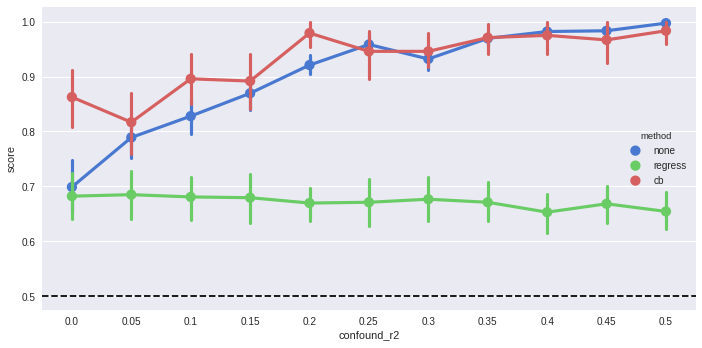

In [24]:
n_splits = 10
permutations = 3

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

data_args = dict(n_samp=240, k_feat=5, c_type='categorical', corr_cy=0.8,
                 signal_r2=0.1, confound_r2=None, verbose=False)

results = []
for perm in np.arange(permutations):
    print(perm)
    for confound_r2 in np.linspace(0.00, 0.5, 11):
        
        data_args.update(confound_r2=confound_r2)
        X, y, c = generate_data(**data_args)
        results.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
        results.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))
        results.append(run_with_counterbalancing(X, y, c, pipeline, n_splits, data_args))

sns.set(font_scale=1)
df = pd.concat(results)
g = sns.factorplot(x='confound_r2', y='score', hue='method', data=df, size=5, aspect=2, legend_out=False,
                   palette="muted", legend=True)
plt.axhline(0.5, c='black', ls='--')
plt.show()

## Scenario 2: what happens when we vary $\rho(yc)$?
... or, in other words, what happens when we increase the initial correlation between the target (y) and the confound (c)?

0
1
2


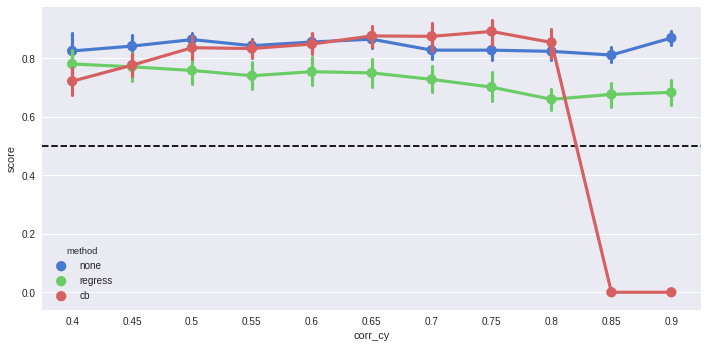

In [27]:
n_splits = 10
permutations = 3

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

data_args = dict(n_samp=240, k_feat=5, c_type='categorical', corr_cy=None,
                 signal_r2=0.1, confound_r2=0.1, verbose=False)

results = []
for perm in np.arange(permutations):
    print(perm)
    for corr_cy in np.linspace(0.4, 0.9, 11):
        
        data_args.update(corr_cy=corr_cy)
        X, y, c = generate_data(**data_args)
        results.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
        results.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))
        results.append(run_with_counterbalancing(X, y, c, pipeline, n_splits, data_args))

sns.set(font_scale=1)
df = pd.concat(results)
g = sns.factorplot(x='corr_cy', y='score', hue='method', data=df, size=5, aspect=2, legend_out=False,
                   palette="muted", legend=True)
plt.axhline(0.5, c='black', ls='--')
plt.show()

## Scenario 3: what happens when we vary $\rho(yx.c)$?
... or, in other words, what happens in we increase the true (unconfounded) signal?

0
1
2


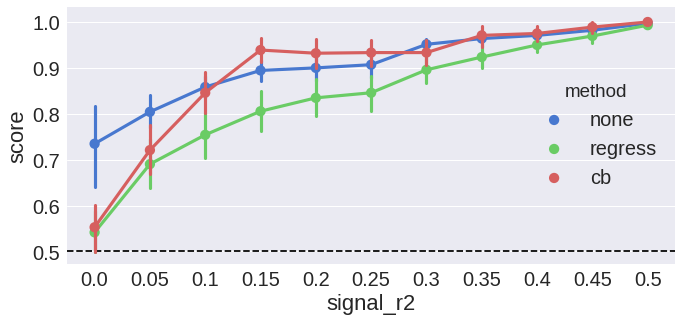

In [29]:
n_splits = 10
permutations = 3

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

data_args = dict(n_samp=240, k_feat=5, c_type='categorical', corr_cy=0.6,
                 signal_r2=None, confound_r2=0.1, verbose=False)

results = []
for perm in np.arange(permutations):
    print(perm)
    for signal_r2 in np.linspace(0.0, 0.5, 11):
        
        data_args.update(signal_r2=signal_r2)
        X, y, c = generate_data(**data_args)
        results.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
        results.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))
        results.append(run_with_counterbalancing(X, y, c, pipeline, n_splits, data_args))

df = pd.concat(results)
g = sns.factorplot(x='signal_r2', y='score', hue='method', data=df, size=5, aspect=2, legend_out=False,
                   palette="muted", legend=True)
plt.axhline(0.5, c='black', ls='--')
plt.show()

## Scenario 4: what happens if we vary the number of samples? 

0
1
2


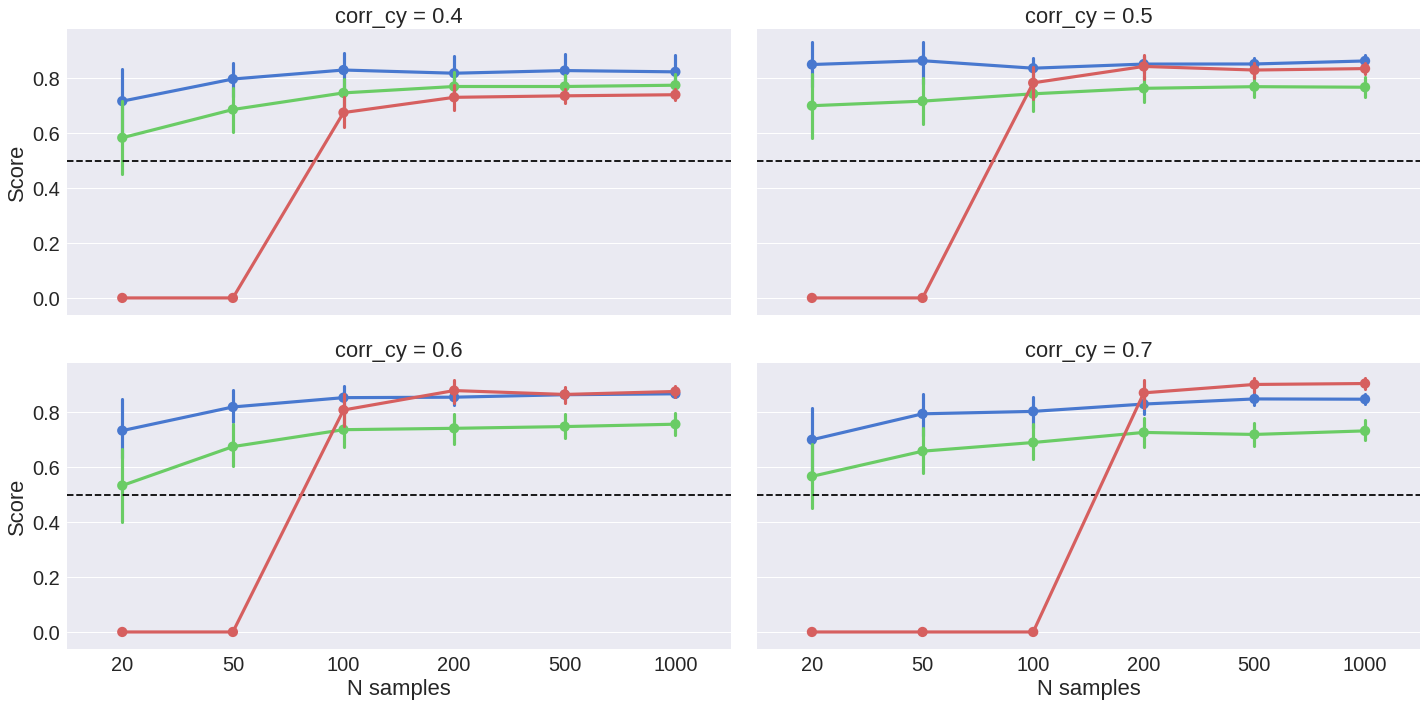

In [28]:
n_splits = 10
permutations = 3

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

data_args = dict(n_samp=None, k_feat=5, c_type='categorical', corr_cy=None,
                 signal_r2=0.1, confound_r2=0.1, verbose=False)

results = []
for perm in np.arange(permutations):
    print(perm)
    for n_samp in [20, 50, 100, 200, 500, 1000]:
        data_args.update(n_samp=n_samp)
        
        for corr_cy in [0.4, 0.5, 0.6, 0.7]:
            data_args.update(corr_cy=corr_cy)
            X, y, c = generate_data(**data_args)
            results.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_counterbalancing(X, y, c, pipeline, n_splits, data_args))

sns.set(font_scale=2)
df = pd.concat(results)
g = sns.factorplot(x='n_samp', y='score', hue='method', col='corr_cy', col_wrap=2,
                   data=df, size=5, aspect=2, legend_out=False,
                   palette="muted", legend=True)
g.map(plt.axhline, y=0.5, c='black', ls='--')
g.set_axis_labels('N samples', 'Score')
plt.show()

## Scenario 5: what happens when we vary the number of features?
We also vary the strength of the confound signal in X (confound_r2).

In [ ]:
n_splits = 10
permutations = 3

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

data_args = dict(n_samp=120, k_feat=None, c_type='categorical', corr_cy=0.6,
                 signal_r2=0.1, confound_r2=None, verbose=False)

results = []
for perm in np.arange(permutations):
    for k_feat in [1, 5, 10, 20, 50, 100, 500, 1000, 10000]:
        data_args.update(k_feat=k_feat)
        
        for confound_r2 in [0, 0.1, 0.2, 0.3]:
            data_args.update(confound_r2=confound_r2)
            X, y, c = generate_data(**data_args)
            results.append(run_without_confound_control(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_confound_regression(X, y, c, pipeline, n_splits, data_args))
            results.append(run_with_counterbalancing(X, y, c, pipeline, n_splits, data_args))

sns.set(font_scale=2)
df = pd.concat(results)
g = sns.factorplot(x='k_feat', y='score', hue='method', col='confound_r2', col_wrap=2,
                   data=df, size=5, aspect=2, legend_out=False,
                   palette="muted", legend=True)
g.map(plt.axhline, y=0.5, c='black', ls='--')
g.set_axis_labels('N samples', 'Score')
plt.show()

## Messing around

In [ ]:
n_splits = 10
X, y, c = generate_data(n_samp=240, k_feat=5, c_type='categorical', corr_cy=0.6,
                        signal_r2=0.1, confound_r2=0.2, verbose=False)

skf = CounterbalancedStratifiedSplit(X, y, c, n_splits=n_splits, c_type='categorical', verbose=True)
skf.check_counterbalance_and_subsample()

X, y, c = X[skf.subsample_idx], y[skf.subsample_idx], c[skf.subsample_idx]    

scores = np.zeros(n_splits)
y_c_r2 = np.zeros(n_splits)
y_xc_r2 = np.zeros((n_splits, X.shape[1]))
y_x_r2 = np.zeros((n_splits, X.shape[1]))
unique_var_x = np.zeros((n_splits, X.shape[1]))
unique_var_c = np.zeros((n_splits, X.shape[1]))
shared_var_xc = np.zeros((n_splits, X.shape[1]))

this_pipe = Pipeline(pipeline)

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    c_train = c[train_idx][:, np.newaxis]
    y_c_r2[i] = get_r2(c_train, y_train)
    
    for ii in range(X_train.shape[1]):
        y_xc_r2[i, ii] = get_r2(np.hstack((X_train[:, ii][:, np.newaxis], c_train)), y_train)
        y_x_r2[i, ii] = get_r2(X_train[:, ii], y_train)
        
        resid_y = 1 - y_xc_r2[i, ii]  # A = 1 - (B + C + D)
        unique_var_x[i, ii] = y_xc_r2[i, ii] - y_c_r2[i]  # B
        unique_var_c[i, ii] = y_xc_r2[i, ii] - y_x_r2[i, ii]  # D
        shared_var_xc[i, ii] = 1 - resid_y - unique_var_x[i, ii] - unique_var_c[i, ii]  # C = 
    
    print("R2(y_xc)): %r" % np.round(y_xc_r2.mean(axis=0), 4).tolist())
    print("R2(y_x): %r" % np.round(y_x_r2.mean(axis=0), 4).tolist())
    print("R2(signal): %r" % np.round(unique_var_x.mean(axis=0), 4).tolist())
    print("R2(confound): %r" % np.round(shared_var_xc.mean(axis=0), 4).tolist())
    
    print('')
    
    this_pipe.fit(X_train, y_train)
    scores[i] = this_pipe.score(X_test, y_test)
print(scores.mean())

In [ ]:
n_splits = 10
X, y, c = generate_data(n_samp=240, k_feat=5, c_type='categorical', corr_cy=0.4,
                        signal_r2=0.1, confound_r2=0.1, verbose=False)

scores = np.zeros(n_splits)
y_c_r2 = np.zeros(n_splits)
y_xc_r2 = np.zeros((n_splits, X.shape[1]))
y_x_r2 = np.zeros((n_splits, X.shape[1]))
unique_var_x = np.zeros((n_splits, X.shape[1]))
unique_var_c = np.zeros((n_splits, X.shape[1]))
shared_var_xc = np.zeros((n_splits, X.shape[1]))

skf = StratifiedKFold(n_splits=n_splits)
this_pipe = Pipeline(pipeline)
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    cr = ConfoundRegressor(confound=c, fit_idx=train_idx, cross_validate=True)
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    c_train = c[train_idx][:, np.newaxis]
    y_c_r2[i] = get_r2(c_train, y_train)

    X_train = cr.fit_transform(X_train)
    X_test = cr.transform(X_test)
    
    for ii in range(X_train.shape[1]):
        y_xc_r2[i, ii] = get_r2(np.hstack((X_train[:, ii][:, np.newaxis], c_train)), y_train)
        y_x_r2[i, ii] = get_r2(X_train[:, ii], y_train)
        
        resid_y = 1 - y_xc_r2[i, ii]  # A = 1 - (B + C + D)
        unique_var_x[i, ii] = y_xc_r2[i, ii] - y_c_r2[i]  # B
        unique_var_c[i, ii] = y_xc_r2[i, ii] - y_x_r2[i, ii]  # D
        shared_var_xc[i, ii] = 1 - resid_y - unique_var_x[i, ii] - unique_var_c[i, ii]  # C = 
    
    print("R2(y_xc)): %r" % np.round(y_xc_r2.mean(axis=0), 4).tolist())
    print("R2(y_x): %r" % np.round(y_x_r2.mean(axis=0), 4).tolist())
    print("R2(signal): %r" % np.round(unique_var_x.mean(axis=0), 4).tolist())
    print("R2(confound): %r" % np.round(shared_var_xc.mean(axis=0), 4).tolist())
    
    print('')
    
    this_pipe.fit(X_train, y_train)
    scores[i] = this_pipe.score(X_test, y_test)
print(scores.mean())